In [1]:
import nltk
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import torch
from fastai import *
from fastai.vision import *


#processing tokens
import unicodedata 
import re
import inflect 

#tokenize
from nltk import word_tokenize, sent_tokenize

#find ngrams
from nltk.util import ngrams

import time

In [2]:
file = open("data.txt").read()

In [3]:
start = time.time()
sentences = sent_tokenize(file)
tokenised_sentences = []
tokens = word_tokenize(file)

# now loop over each sentence and tokenize it separately
for sentence in sentences:
    tokenised_sentences.append(word_tokenize(sentence))

end = time.time()
print(end-start)

0.028067350387573242


In [4]:
#normalise tokens manually

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words


def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    #words = remove_stopwords(words)
    return words

start = time.time()
data_sen = []

for x in range(len(tokenised_sentences)):
    data_sen.append(normalize(tokenised_sentences[x]))

data_tokens = normalize(tokens)
    
end = time.time()

print(end-start)

0.0039577484130859375


In [5]:
print(data_sen[:5])
print(data_tokens[:10])

[['how', 'thor', 'got', 'the', 'hammer'], ['sif', 'was', 'thor', 's', 'wife'], ['sif', 'had', 'long', 'golden', 'hair'], ['thor', 'was', 'very', 'proud', 'of', 'sif', 's', 'golden', 'hair'], ['thor', 'was', 'always', 'going', 'on', 'long', 'journeys']]
['how', 'thor', 'got', 'the', 'hammer', 'sif', 'was', 'thor', 's', 'wife']


In [6]:
trigrams = ngrams(data_tokens, 3)
tg_list = list(trigrams)

In [7]:
print(list(trigrams)[:10])

[]


In [8]:
print(tg_list[0])

('how', 'thor', 'got')


In [9]:
fd = nltk.FreqDist(tg_list)

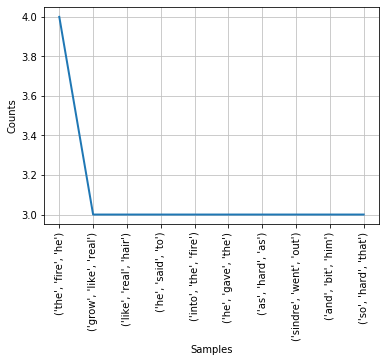

[(('the', 'fire', 'he'), 4),
 (('grow', 'like', 'real'), 3),
 (('like', 'real', 'hair'), 3),
 (('he', 'said', 'to'), 3),
 (('into', 'the', 'fire'), 3),
 (('he', 'gave', 'the'), 3),
 (('as', 'hard', 'as'), 3),
 (('sindre', 'went', 'out'), 3),
 (('and', 'bit', 'him'), 3),
 (('so', 'hard', 'that'), 3)]

In [10]:
fd.plot(10)
fd.most_common(10)

In [11]:
print(fd.r_Nr()[0])
print(fd.r_Nr()[1])
print(fd.r_Nr()[2])
print(fd.r_Nr()[3])
print(fd.r_Nr()[4])
#total
print(fd.N())

0
1025
59
14
1
1189


# WRONG

In [12]:
from sklearn.preprocessing import OneHotEncoder
import itertools

start = time.time()

#set() - no duplicates
#{} - dictionray, maps individual tokens to key
word_to_id = {token: idx for idx, token in enumerate(set(data_tokens))}

print(tg_list[0])

# convert token lists to token-id lists, e.g. [[1, 2], [2, 2]] here
data_tokens_ids = [[word_to_id[token] for token in trigram] for trigram in tg_list]

print(data_tokens_ids[0])
#converting back to words
for token_id in data_tokens_ids[0]:
    print(list(word_to_id)[token_id])

vec = OneHotEncoder(categories='auto')
X = vec.fit_transform(data_tokens_ids)
tg_OneHot = X.toarray()

print (tg_OneHot)
end = time.time()
print(end-start)

('how', 'thor', 'got')
[76, 190, 136]
how
thor
got
[[0. 0. 0. 0. ... 0. 0. 0. 0.]
 [0. 0. 0. 0. ... 0. 0. 0. 0.]
 [0. 0. 0. 0. ... 0. 0. 0. 0.]
 [0. 0. 0. 0. ... 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. ... 0. 0. 0. 0.]
 [0. 0. 0. 0. ... 0. 0. 0. 0.]
 [0. 0. 0. 0. ... 0. 0. 0. 0.]
 [0. 0. 0. 0. ... 0. 0. 0. 0.]]
0.008758544921875


In [13]:
tg_counts = [fd.freq(trigram)*fd.N() for trigram in tg_list]
tg_prob = [fd.freq(trigram) for trigram in tg_list]

#print(tg_counts)

print(tg_list[0])
#print(tg_OneHot[0])
print(tg_counts[0])
print(tg_prob[0])

('how', 'thor', 'got')
1.0
0.0008410428931875525


# RATHER

In [14]:
start = time.time()

#{} - dictionary, maps individual tokens to key
id_to_ngram = {idx: ngram for idx, ngram in enumerate(tg_list)}
ngram_to_id = {ngram: idx for idx, ngram in enumerate(tg_list)}

no_tg = fd.N()

frequencies = [fd.freq(id_to_ngram[x]) for x in range(no_tg)]
ngram_freq = np.identity(no_tg)*frequencies

print(ngram_freq)

end = time.time()
print(end-start)

[[0.000841 0.       0.       0.       ... 0.       0.       0.       0.      ]
 [0.       0.000841 0.       0.       ... 0.       0.       0.       0.      ]
 [0.       0.       0.000841 0.       ... 0.       0.       0.       0.      ]
 [0.       0.       0.       0.000841 ... 0.       0.       0.       0.      ]
 ...
 [0.       0.       0.       0.       ... 0.000841 0.       0.       0.      ]
 [0.       0.       0.       0.       ... 0.       0.000841 0.       0.      ]
 [0.       0.       0.       0.       ... 0.       0.       0.000841 0.      ]
 [0.       0.       0.       0.       ... 0.       0.       0.       0.000841]]
0.008357763290405273


# Neural Net



In [15]:
import torch.nn as nn
from torch import optim
from sklearn import preprocessing
# inputs - total ngrams - different ngram count - ngram occurence

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3, 3)
        self.fc2 = nn.Linear(3, 1)

        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x)) 
        return x

# Creating Fast Ai Dataset

In [17]:
# tensor x : total ngrams - different ngram count - ngram occurence
# target : count/total

class ArrayDataset(Dataset):
    "Sample numpy array dataset"
    def __init__(self, x): #[1 , 3] dimension
        self.x = x
        self.y = torch.zeros(len(x),dtype = torch.float)
        for i in range(len(x)):
            self.y[i] = (x[i][1]/x[i][0])

            
        self.c = 1 # binary label
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    

# data

In [18]:
inputs = torch.zeros(4,3, dtype = torch.float)

for x in range(4): #x starts at zero

    total = fd.N()
    count = fd.r_Nr()[x+1]
    occurence = x+1  
    
    inputs[x][0] = total
    inputs[x][1] = count
    inputs[x][2] = occurence
    
    print(inputs[x][1]/inputs[x][0])

print(inputs)

tensor(0.8621)
tensor(0.0496)
tensor(0.0118)
tensor(0.0008)
tensor([[1.1890e+03, 1.0250e+03, 1.0000e+00],
        [1.1890e+03, 5.9000e+01, 2.0000e+00],
        [1.1890e+03, 1.4000e+01, 3.0000e+00],
        [1.1890e+03, 1.0000e+00, 4.0000e+00]])


# Normalize

In [19]:
inputs = preprocessing.normalize(inputs)
inputs = torch.from_numpy(inputs)
print(inputs)

tensor([[7.5741e-01, 6.5294e-01, 6.3701e-04],
        [9.9877e-01, 4.9560e-02, 1.6800e-03],
        [9.9993e-01, 1.1774e-02, 2.5229e-03],
        [9.9999e-01, 8.4104e-04, 3.3642e-03]], dtype=torch.float64)


In [20]:
train = inputs

rand = torch.ones(3, dtype = torch.double).uniform_(0.9,1.1)
valid = (inputs*rand).float()
train = train.float()

print(train)
print(valid)

tensor([[7.5741e-01, 6.5294e-01, 6.3701e-04],
        [9.9877e-01, 4.9560e-02, 1.6800e-03],
        [9.9993e-01, 1.1774e-02, 2.5229e-03],
        [9.9999e-01, 8.4104e-04, 3.3642e-03]])
tensor([[6.9534e-01, 6.4755e-01, 6.7786e-04],
        [9.1692e-01, 4.9151e-02, 1.7878e-03],
        [9.1798e-01, 1.1677e-02, 2.6847e-03],
        [9.1804e-01, 8.3409e-04, 3.5799e-03]])


In [21]:
train_ds, valid_ds = ArrayDataset(train), ArrayDataset(valid)
data = DataBunch.create(train_ds, valid_ds, bs=2)
data.one_batch()

(tensor([[0.9988, 0.0496, 0.0017],
         [0.9999, 0.0118, 0.0025]]), tensor([0.0496, 0.0118]))

In [22]:
target = torch.zeros(len(train))

for i in range(len(train)):
    target[i] = (train[i][1]/train[i][0])

print(target)    

tensor([8.6207e-01, 4.9622e-02, 1.1775e-02, 8.4104e-04])


# Manual Training

In [83]:
net = Net()
optimizer = optim.SGD(net.parameters(), lr=0.03, momentum=0.1)
criterion = torch.nn.SmoothL1Loss()

In [103]:
start = time.time()

for epoch in range(1, 1000): ## run the model for 10 epochs

    for x in range(len(train)): #x starts at zero
           
        #print(inputs)
        #print(inputs.dtype)

        optimizer.zero_grad()
        
        ## 1. forward propagation
        net_out = net(train[x])
        #print(train[x])
        
        ## 2. loss calculation
        loss = criterion(net_out, target[x])
        #print(target[x])
        
        ## 3. backward propagation
        loss.backward()
        
        ## 4. weight optimization
        optimizer.step()
        
        if(epoch % 100 == 1):
            print('Train Epoch: {} \tLoss: {:.6f}'.format(
                epoch, 
                loss.data))

end = time.time()
print(end-start)

Train Epoch: 1 	Loss: 0.123875
Train Epoch: 1 	Loss: 0.033438
Train Epoch: 1 	Loss: 0.042931
Train Epoch: 1 	Loss: 0.046046
Train Epoch: 101 	Loss: 0.122189
Train Epoch: 101 	Loss: 0.025925
Train Epoch: 101 	Loss: 0.033924
Train Epoch: 101 	Loss: 0.036546
Train Epoch: 201 	Loss: 0.101177
Train Epoch: 201 	Loss: 0.022653
Train Epoch: 201 	Loss: 0.029481
Train Epoch: 201 	Loss: 0.031553
Train Epoch: 301 	Loss: 0.068859
Train Epoch: 301 	Loss: 0.020284
Train Epoch: 301 	Loss: 0.025874
Train Epoch: 301 	Loss: 0.027581
Train Epoch: 401 	Loss: 0.040333
Train Epoch: 401 	Loss: 0.016765
Train Epoch: 401 	Loss: 0.021068
Train Epoch: 401 	Loss: 0.023323
Train Epoch: 501 	Loss: 0.021618
Train Epoch: 501 	Loss: 0.013592
Train Epoch: 501 	Loss: 0.016952
Train Epoch: 501 	Loss: 0.018996
Train Epoch: 601 	Loss: 0.012092
Train Epoch: 601 	Loss: 0.010706
Train Epoch: 601 	Loss: 0.013411
Train Epoch: 601 	Loss: 0.015233
Train Epoch: 701 	Loss: 0.007283
Train Epoch: 701 	Loss: 0.008377
Train Epoch: 701 	

# Build Learner

fast.ai Learner() expects an object with a list of models. We create a shell object to return this type.



In [25]:
criterion = torch.nn.SmoothL1Loss()

net2 = Net().cuda()

In [26]:
learn = Learner(data, net2, opt_func = torch.optim.SGD, loss_func = criterion)

In [72]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


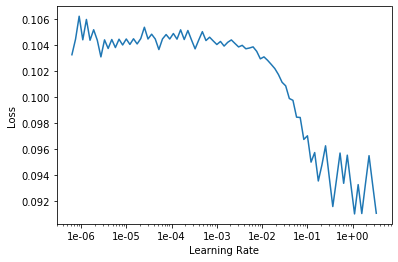

In [73]:
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,time
0,0.105700,0.112277,00:00
1,0.105817,0.112205,00:00
2,0.105877,0.112031,00:00
3,0.105753,0.111756,00:00
4,0.105701,0.111514,00:00
5,0.105600,0.111264,00:00
6,0.105438,0.111066,00:00
7,0.105320,0.110934,00:00
8,0.105230,0.110877,00:00
9,0.105141,0.110861,00:00


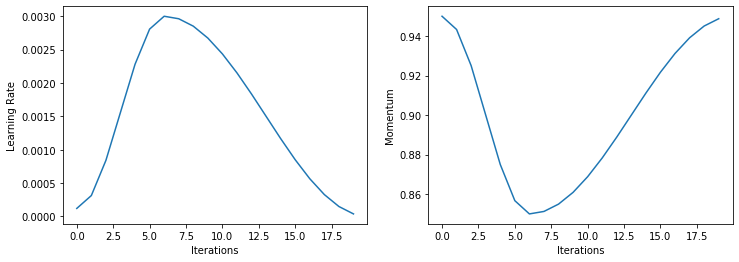

In [30]:
learn.recorder.plot_lr(show_moms=True)

# Saving model

In [181]:
torch.save(net.state_dict(), 'save/net')

# Loading model

In [182]:
model = Net()
model.load_state_dict(torch.load('save/net'))
model.eval()

Net(
  (fc1): Linear(in_features=3, out_features=3, bias=True)
  (fc2): Linear(in_features=3, out_features=1, bias=True)
)

# Result

## manual traingin

In [180]:
print(model(torch.Tensor([1, 0.05, 0.001])))

tensor([0.1384], grad_fn=<SigmoidBackward>)


In [183]:
x = torch.Tensor(500,3)
y = torch.Tensor(500)

for i in range (500):
    x[i] = torch.Tensor([1, i/1000, 0.01])
    y[i] = model(x[i])

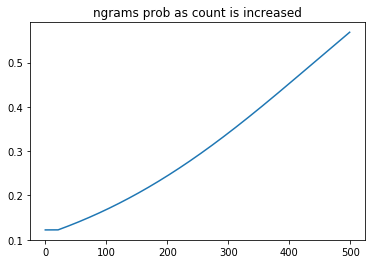

In [184]:
plt.plot(y)
plt.title("ngrams prob as count is increased")
plt.show()

given total of 1000 ngrams and occurence for this ngram to be 10

In [185]:
x = torch.Tensor(10,3)
y = torch.Tensor(10)

for i in range (10):
    x[i] = torch.Tensor([1, 0.05, i/1000])
    y[i] = model(x[i])

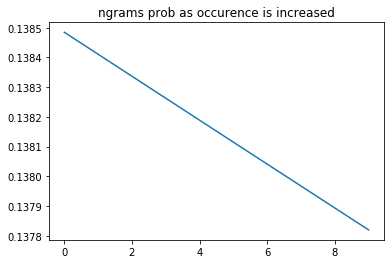

In [161]:
plt.plot(y)
plt.title("ngrams prob as occurence is increased")
plt.show()

given total of 1000 ngrams and count of ngram be 50